In [1]:
import os
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')

# Check if TensorFlow has access to GPU
if len(physical_devices) > 0:
    print(f"GPUs detected: {len(physical_devices)}")
    # Set memory growth to True for all GPUs
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
    print(f"Memory growth set to True")
else:
    print("No GPUs detected. Please check your CUDA and cuDNN setup.")

GPUs detected: 8
Memory growth set to True


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, BatchNormalization, concatenate, Layer, Lambda, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

In [3]:
N = 10000

m_true = np.random.normal(0, 1, N)
m_reco = np.random.normal(m_true, 1)
m_true_alt = np.random.normal(0.5, 1, N)
m_reco_alt = np.random.normal(m_true_alt, 1)

In [4]:
SIGNAL_VALUE = -999
N = len(m_true)
signal_array = np.full(N, SIGNAL_VALUE)
substructure_variables = ['m']

xvals_truth = np.array([np.concatenate([globals()[f"{var_name}_true_alt"], globals()[f"{var_name}_true"]]) for var_name in substructure_variables]).T
xvals_signal = np.array([np.concatenate([globals()[f"{var_name}_true_alt"], globals()["signal_array"]]) for var_name in substructure_variables]).T
xvals_reco = np.array([np.concatenate([globals()[f"{var_name}_reco_alt"], globals()[f"{var_name}_reco"]]) for var_name in substructure_variables]).T
                    
yvals = np.concatenate([np.zeros(N, dtype=np.float32),np.ones(N, dtype=np.float32)])

X_train_truth, X_test_truth, X_train_signal, X_test_signal, X_train_reco, X_test_reco, Y_train, Y_test = train_test_split(
    xvals_truth, xvals_signal, xvals_reco, yvals)


In [11]:
tf.keras.utils.get_custom_objects().clear()
@tf.keras.utils.register_keras_serializable(package="Custom", name="weighted_binary_crossentropy")
def weighted_binary_crossentropy(target, output, weights):
    target = tf.convert_to_tensor(target, dtype=tf.float32)
    output = tf.convert_to_tensor(output, dtype=tf.float32)
    weights = tf.convert_to_tensor(weights, dtype=tf.float32)
    
    epsilon_ = tf.keras.backend.epsilon()
    output = tf.clip_by_value(output, epsilon_, 1.0 - epsilon_)
    
    weights_1 = K.sum(target * weights)
    weights_0 = K.sum((1 - target) * weights)
    
    bce_1 = target * K.log(output + epsilon_) * weights / weights_1
    bce_0 = (1 - target) * K.log(1 - output + epsilon_) * weights / weights_0
    weighted_bce = -K.mean(bce_1 + bce_0)
    return weighted_bce
    
@tf.keras.utils.register_keras_serializable(package="Custom", name="weighted_binary_crossentropy_GAN")
def weighted_binary_crossentropy_GAN(target, output, weights):

    target = tf.convert_to_tensor(target, dtype=tf.float32)
    output = tf.convert_to_tensor(output, dtype=tf.float32)
    weights = tf.convert_to_tensor(weights, dtype=tf.float32)

    epsilon_ = tf.keras.backend.epsilon()
    output = tf.clip_by_value(output, epsilon_, 1.0 - epsilon_)
    
    weights_sum = K.sum((1 - target) * weights)
    bce = K.mean(weights * (1 - target) * K.log(1 - output + epsilon_) / weights_sum)
    return bce



In [12]:
#Create the generator model
mymodel_inputtest = Input(shape=(xvals_signal.shape[1],))
hidden_layer_1 = Dense(50, activation='relu', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.2))(mymodel_inputtest)
batch_norm_1 = BatchNormalization()(hidden_layer_1)
hidden_layer_2 = Dense(50, activation='relu', use_bias=False)(batch_norm_1)
batch_norm_2 = BatchNormalization()(hidden_layer_2)
hidden_layer_3 = Dense(50, activation='relu', use_bias=False)(batch_norm_2)
softplus_output = Dense(1, activation='softplus', use_bias=False)(hidden_layer_3)
outputs = Lambda(lambda x: x / K.log(2.0))(softplus_output)  # Scale output by log(2)

model_generator = Model(inputs=mymodel_inputtest, outputs=outputs)
                       
#Create the discriminator model, and compile it while model_discrimintor.trainable is still true so that model_discrimintor.train_on_batch will cause the discriminator to train on loss=weighted_binary_crossentropy, while the generator is constant

inputs_disc = Input((xvals_reco.shape[1], ))
hidden_layer_1_disc = Dense(50, activation='relu')(inputs_disc)
hidden_layer_2_disc = Dense(50, activation='relu')(hidden_layer_1_disc)
hidden_layer_3_disc = Dense(50, activation='relu')(hidden_layer_2_disc)
outputs_disc = Dense(1, activation='sigmoid')(hidden_layer_3_disc)
model_discriminator = Model(inputs=inputs_disc, outputs=outputs_disc)
model_discriminator.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.4))
    

In [13]:
optimizer_disc = Adam(learning_rate=0.0002, beta_1=0.4)
optimizer_gen = Adam(learning_rate=0.0001, beta_1=0.5)

@tf.function
def train_step_discriminator(X_detector_batch, Y_batch, W_batch):
    model_discriminator.trainable = True
    with tf.GradientTape() as tape:
        predictions = model_discriminator(X_detector_batch, training=True)
        loss = weighted_binary_crossentropy(Y_batch, predictions, W_batch)
    grads = tape.gradient(loss, model_discriminator.trainable_variables)
    optimizer_disc.apply_gradients(zip(grads, model_discriminator.trainable_variables))
    return loss

@tf.function
def train_step_gan(X_particle_batch, X_detector_batch, Y_batch):
    with tf.GradientTape() as tape:
        W_batch = model_generator(X_particle_batch, training=True) 
        W_batch = tf.where(Y_batch == 1, 1.0, tf.squeeze(W_batch))
        model_discriminator.trainable = False   
        discriminator_output = model_discriminator(X_detector_batch, training=False)  
        loss = weighted_binary_crossentropy_GAN(Y_batch, discriminator_output, W_batch)
    grads = tape.gradient(loss, model_generator.trainable_variables)
    optimizer_gen.apply_gradients(zip(grads, model_generator.trainable_variables))
    return loss


In [14]:
discriminator_losses = []
generator_losses = []

n_epochs = 5
batch_size = N//100

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_reco, X_train_signal, Y_train)).batch(batch_size)

for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}/{n_epochs}")

    for X_detector_batch, X_particle_batch, Y_batch in train_dataset:
        W_batch = model_generator.predict(X_particle_batch, verbose=0)
        W_batch = tf.where(Y_batch == 1, 1.0, tf.squeeze(W_batch))

        d_loss = train_step_discriminator(X_detector_batch, Y_batch, W_batch)
        g_loss = train_step_gan(X_particle_batch, X_detector_batch, Y_batch)

        discriminator_losses.append(d_loss.numpy())
        generator_losses.append(g_loss.numpy())

    # Log the average losses for the epoch
    avg_d_loss = np.mean(discriminator_losses[-len(train_dataset):])
    avg_g_loss = np.mean(generator_losses[-len(train_dataset):])
    print(f"Epoch {epoch+1} completed. Discriminator Loss: {avg_d_loss}, Generator Loss: {avg_g_loss}")


Epoch 1/5
Epoch 1 completed. Discriminator Loss: 0.013866961933672428, Generator Loss: -0.006900312844663858
Epoch 2/5
Epoch 2 completed. Discriminator Loss: 0.013862956315279007, Generator Loss: -0.00693307863548398
Epoch 3/5
Epoch 3 completed. Discriminator Loss: 0.013862942345440388, Generator Loss: -0.006931876298040152
Epoch 4/5
Epoch 4 completed. Discriminator Loss: 0.013862940482795238, Generator Loss: -0.006931649055331945
Epoch 5/5
Epoch 5 completed. Discriminator Loss: 0.01386293862015009, Generator Loss: -0.006931541953235865


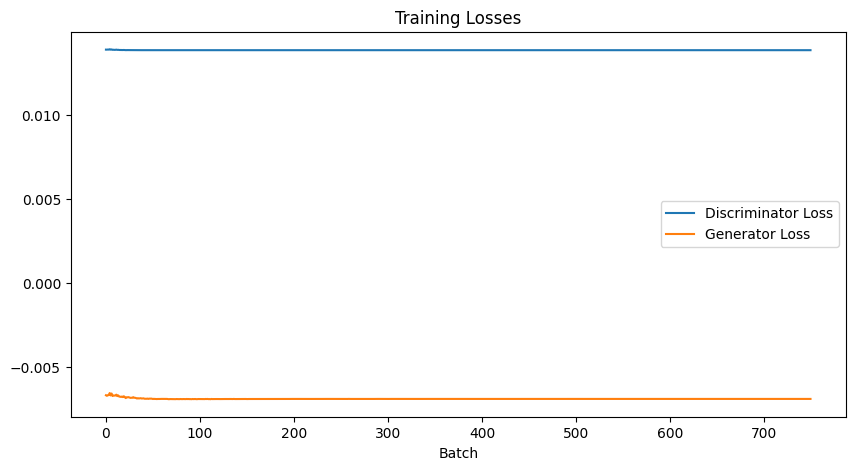

In [15]:
## Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(discriminator_losses, label='Discriminator Loss')
plt.plot(generator_losses, label='Generator Loss')
plt.title('Training Losses')
plt.xlabel('Batch')
plt.legend()
plt.show()

In [17]:
#Now apply the generator to x_true_alt, to get the weights at truth level
weights = model_generator.predict(X_test_truth[Y_test==0])

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [18]:
weights

array([[0.2960077 ],
       [0.31115517],
       [0.4350126 ],
       ...,
       [0.11658875],
       [0.2955276 ],
       [0.55442894]], dtype=float32)

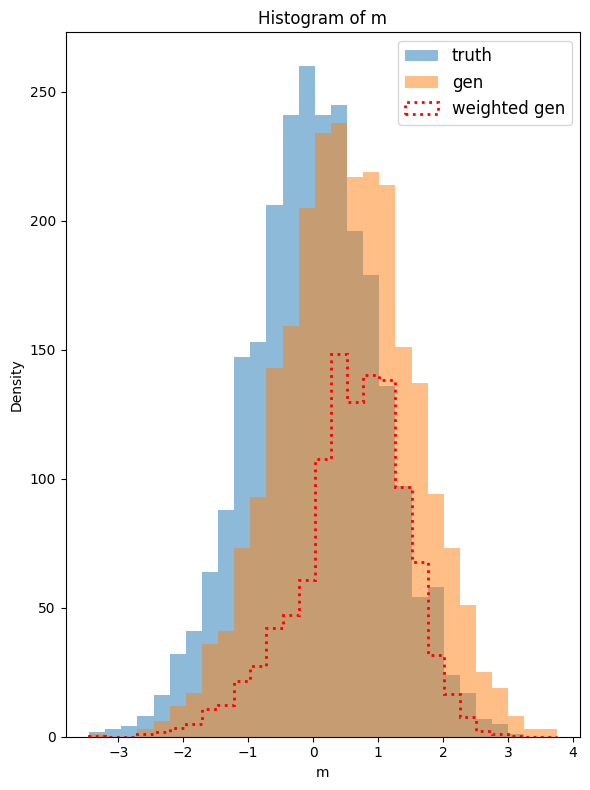

In [28]:
fig, axs = plt.subplots(figsize=(6, 8))
nbins = 30
density = False

for i, var_name in enumerate(substructure_variables):
    # Assuming X_test_truth is structured so that columns correspond to variables in substructure_variables
    X = X_test_truth[:, i]  # Get the i-th variable
    bins = np.linspace(X.min(), X.max(), nbins)
    
    axs.hist(X[Y_test == 1], bins=bins, alpha=0.5, label="truth", density=density, zorder=-1)
    axs.hist(X[Y_test == 0], bins=bins, alpha=0.5, label="gen", density=density, zorder=0)
    axs.hist(X[Y_test == 0], bins=bins, weights=weights, histtype="step", color="red", ls=":", lw=2, label="weighted gen", density=density, zorder=1)
    
    axs.legend(fontsize=12)
    axs.set_ylabel("Density")
    axs.set_xlabel(var_name)  # Use the variable name as the x-axis label
    axs.set_title(f"Histogram of {var_name}")  # Optionally set a title for each subplot


plt.tight_layout()
plt.show()
